In [1]:
import csv
import re
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..") # adds higher directory to python modules path

from LoaderPACK.Unet_leaky import Unet_leaky
from LoaderPACK.Loader import load_whole_data, load_shuffle_5_min
import torch

In [2]:
def lorenz_curve(ls: list, name: str):
    tot_sum = sum(ls) # get the total sum of intervals
    nr_patients = len(ls)
    sorted_ls = sorted(ls)
    
    res = []
    rang = [i/100 for i in range(0, 100 + 5, 5)]
    for per in rang:
        res.append(sum(sorted_ls[:math.floor(nr_patients * per)])/tot_sum)
    
    plt.title(f"Lorenz Curve of {name}")
    plt.xlabel("Cummulative % of patients")
    plt.ylabel("Cummulative % of intervals")
    plt.plot(rang, res)
    plt.plot(rang, rang)
    return plt

In [3]:
path = "C:/Users/Marc/Desktop/model_data/train_model_data"

patient_samples = dict()

with open(path + '/train_encoding.csv', 'r') as file:
    ls = csv.reader(file)
    for rows in ls:
        m = re.match(r".+/\d+/(\d+)/+.", rows[0])
        val_to_dict = patient_samples.get(m.group(1), [])
        val_to_dict.append(rows[2])
        patient_samples[m.group(1)] = val_to_dict

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Marc/Desktop/model_data/train_model_data/train_encoding.csv'

In [5]:
print(patient_samples)

{}


Plot the experiment from a patient:

In [36]:
device = "cpu"

trainload = load_whole_data(path = "C:/Users/Bruger/Desktop/model_data", ind = [i for i in range(1, 20 + 1)])

# Set up the dataloaders:

trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)
it = iter(trainloader)
model_input, model_target, model_data = next(it)

torch.set_printoptions(edgeitems=2)

print(model_input[0])

print()

print(model_target[0])

tensor([[ 4.2013e-13, -9.7947e-01,  ..., -3.0240e-02,  8.4703e-15],
        [-1.4501e-12,  4.4182e-01,  ...,  2.7405e-01,  4.2352e-15],
        ...,
        [-5.4210e-13,  2.7086e-01,  ...,  1.6927e-01, -2.1176e-15],
        [ 1.2197e-13, -1.1390e-01,  ...,  1.4147e-01,  2.9646e-15]])

tensor([[0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.],
        ...,
        [0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.]])


In [5]:
import time


device = "cpu"
print(device)

trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", series_dict = 'train_series_length.pickle', ind = [i for i in range(1, 195 + 1)])

# Set up the dataloaders:

trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)

data_before = []

nr_of_files_loaded = 0

batch_size = 1

start = time.time()

for file in trainloader:
    size = (file[0][0].shape[0], file[0][0].shape[1])
    length = math.floor((size[1]/(200*60*5)))*size[0] # the amount of total possible cuts
    
    data_before.append(length)

print("time:", time.time()-start)
    
print("Number of files loaded in total:", nr_of_files_loaded)



cpu
time: 13.712074518203735
Number of files loaded in total: 0


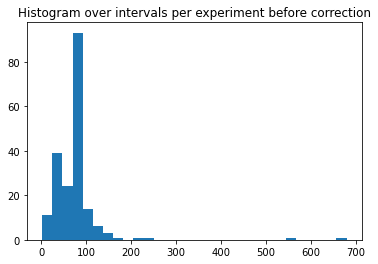

82.21538461538462
88.0


In [6]:
plt.hist(data_before, bins = 30)
plt.title("Histogram over intervals per experiment before correction")
plt.savefig(f"C:/Users/Marc/Desktop/BP photos/hist_exp_before.jpg")
plt.show()
plt.close()


print(np.mean(data_before))
print(np.median(data_before))

In [7]:
patient_before = []

for value in patient_samples.values():
    vals = 0
    for i in value:
        vals += data_before[int(i)-1]
    
    patient_before.append(vals)

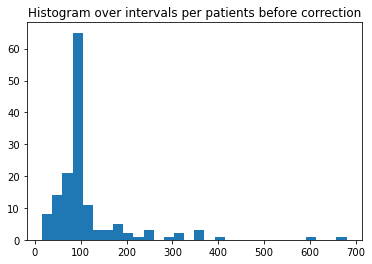

110.56551724137931
88.0


In [8]:
plt.hist(patient_before, bins = 30)
plt.title("Histogram over intervals per patients before correction")
plt.savefig(f"C:/Users/Marc/Desktop/BP photos/hist_patient_before.jpg")
plt.show()
plt.close()

print(np.mean(patient_before))
print(np.median(patient_before))

In [9]:
np.mean(np.array(patient_before) > 88)

0.2620689655172414

In [10]:
np.sum(np.array(patient_before) > 88)

38

In [11]:
np.sum(np.array(patient_before)[np.array(patient_before) > 88])/np.sum(np.array(patient_before))

0.5033058882235529

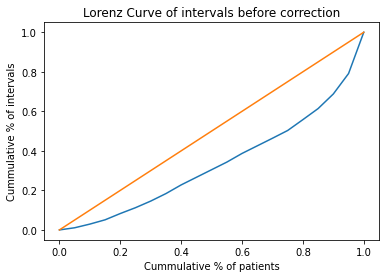

In [14]:
m = lorenz_curve(patient_before, "intervals before correction")

plt.savefig(f"C:/Users/Marc/Desktop/BP photos/Lorenz_before.jpg")
plt.show()
plt.close()


In [15]:
import time


device = "cpu"
print(device)

trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", series_dict = 'train_series_length.pickle', ind = [i for i in range(1, 195 + 1)])

# Set up the dataloaders:

trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)

data_after = []

nr_of_files_loaded = 0

batch_size = 1

start = time.time()

for file in trainloader:
    loader2 = load_shuffle_5_min(file, device)
    loader2 = torch.utils.data.DataLoader(loader2,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=0)
    nr_of_files_loaded += 1
    j = 0
    for i in loader2:
        j += 1
    
    data_after.append(j)

print("time:", time.time()-start)
    
print("Number of files loaded in total:", nr_of_files_loaded)




cpu
time: 11.344902515411377
Number of files loaded in total: 195


In [16]:
patient_after = []

for value in patient_samples.values():
    vals = 0
    for i in value:
        vals += data_after[int(i)-1]
    
    patient_after.append(vals)

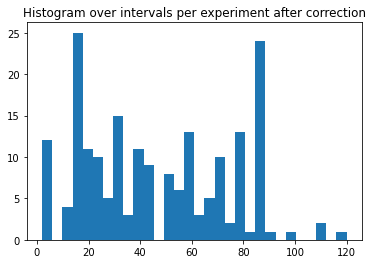

46.717948717948715
44.0


In [21]:
plt.title("Histogram over intervals per experiment after correction")
plt.hist(data_after, bins = 30)
plt.savefig(f"C:/Users/Marc/Desktop/BP photos/hist_exp_after.jpg")
plt.show()
plt.close()

print(np.mean(data_after))
print(np.median(data_after))

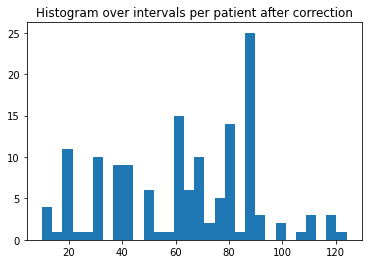

62.827586206896555
66.0


In [22]:
plt.title("Histogram over intervals per patient after correction")
plt.hist(patient_after, bins = 30)
plt.savefig(f"C:/Users/Marc/Desktop/BP photos/hist_patient_after.jpg")
plt.show()
plt.close()



print(np.mean(patient_after))
print(np.median(patient_after))

In [23]:
np.mean(np.array(patient_after) > 66)

0.4827586206896552

In [24]:
np.sum(np.array(patient_after) > 66)

70

In [25]:
np.sum(np.array(patient_after)[np.array(patient_after) > 66])/np.sum(np.array(patient_after))

0.660702524698134

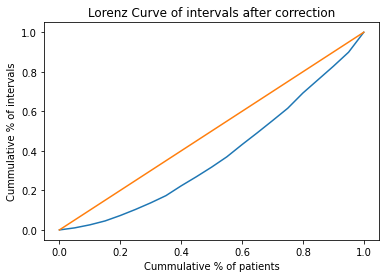

In [26]:
m = lorenz_curve(patient_after, "intervals after correction")

plt.savefig(f"C:/Users/Marc/Desktop/BP photos/Lorenz_after.jpg")
plt.show()
plt.close()

In [27]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import numpy as np
import math
import pickle

class load_shuffle_5_min(Dataset):
    """
    This dataloader loads the tensor input and target in whole
    """
    def __init__(self, ls: list, device):
        """
        Args:
            path (str): path to the input & target folder.
            ind (list): list of indices for which pictures to load.
            device (class 'torch.device'): which pytorch device the data should
            be sent to.
        """

        self.device = device
        self.ls = ls # list with the input and target data
        self.size = (ls[0][0].shape[0], ls[0][0].shape[1])
            # size of target and input

        self.s_len = ls[2][0]
        self.s_num = ls[2][1]

        length = math.floor((self.size[1]/(200*60*5)))*self.size[0]
            # the amount of total possible cuts

        self.length = int(min(torch.div((10 - self.s_len % 10), self.s_num,
                                        rounding_mode='trunc'), length))
            # make sure that no more than 75 samples is taken from the same
            # individual

        self.gen = iter(self.create_data(self.length))


    def create_data(self, nr_of_cuts):
        cut_point = np.random.randint(low = 200*30, #remove the first 30 secs
                            high = self.size[1] - 5*200*60, size = nr_of_cuts)
                            # choose the place to cut

        cuts_pr_chan = nr_of_cuts/self.ls[0][0].shape[0]
            # the amount of cuts pr channel

        for i in range(nr_of_cuts):
            chan = int(i//cuts_pr_chan) # the given channel
            inp = self.ls[0][0][chan][cut_point[i]:cut_point[i]+60*5*200].view(1, 60*5*200)
            tar = self.ls[1][0][chan][cut_point[i]:cut_point[i]+60*5*200].view(1, 60*5*200)
            #inp = self.ls[0][0][chan][cut_point[i]:cut_point[i]+60*5*200]
            #tar = self.ls[1][0][chan][cut_point[i]:cut_point[i]+60*5*200]


            #tar = torch.cat((tar[0], -1*(tar[0] - 1))).view(2, 60*5*200)
            yield (inp, tar, chan)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        inp, tar, chan = next(self.gen)
        inp = inp.to(self.device)
        tar = tar.to(self.device)
        return inp, tar, chan

In [28]:
import time


device = "cpu"
print(device)

trainload = load_whole_data(path = "C:/Users/Marc/Desktop/model_data/train_model_data", series_dict = 'train_series_length.pickle', ind = [i for i in range(1, 195 + 1)])

# Set up the dataloaders:

trainloader = torch.utils.data.DataLoader(trainload,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)

data_very_low = []

nr_of_files_loaded = 0

batch_size = 1

start = time.time()

for file in trainloader:
    loader2 = load_shuffle_5_min(file, device)
    loader2 = torch.utils.data.DataLoader(loader2,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=0)
    nr_of_files_loaded += 1
    j = 0
    for i in loader2:
        j += 1
    
    data_very_low.append(j)

print("time:", time.time()-start)
    
print("Number of files loaded in total:", nr_of_files_loaded)




cpu
time: 14.15889048576355
Number of files loaded in total: 195


In [29]:
patient_low = []

for value in patient_samples.values():
    vals = 0
    for i in value:
        vals += data_very_low[int(i)-1]
    
    patient_low.append(vals)

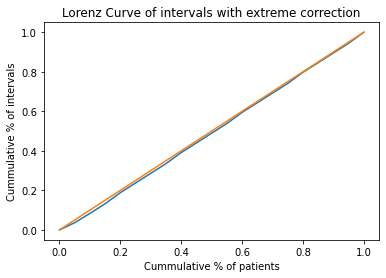

In [32]:
m = lorenz_curve(patient_low, "intervals with extreme correction")

plt.savefig(f"C:/Users/Marc/Desktop/BP photos/Lorenz_low.jpg")
plt.show()
plt.close()